In [258]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import pymongo as pm
from pymongo import MongoClient
from collections import Counter, defaultdict
from tqdm import tqdm
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.ensemble import ExtraTreesClassifier
from scipy.stats import pearsonr

In [5]:
orderedCols = ['matchId', 'teamId', 'isHome',
               'meanPlayerOverall', 'meanPlayerPotential', 'meanPrevScore', 'meanPrevScoreET', 'meanPrevScoreHT', 'meanPrevScoreP',
               'numPass', 'numAccuratePass', 'rateAccuratePass', 
               'numDuel', 'numFoul', 'numFreeKick', 'numGoalkeeperLeavingLine', 'numInterruption', 'numOffside', 'numOthersOnTheBall', 'numSaveAttempt', 'numShot',
               'numYellowCard', 'numSecondYellowCard', 'numRedCard',
               'percBallPoss', 'percOppHalfField',
               'numGoalsFristHalf', 'numSecondHalfGoals', 'finalScore',
               'isWinner', 'didScoreInSecondHalf' ]

In [6]:
b1 = '#D7E8F7'
b2 = '#B3D6ED'
b3 = '#78BFE0'
b4 = '#349CD2'
b5 = '#0077BF'
b6 = '#004FA5'

In [251]:
# create the folde plots in which are saved the plots in pdf format
import os
if not os.path.exists('./plots'):
    os.mkdir('./plots')

# DataFrame

In [8]:
res = pd.read_csv('./results.csv')
res.head()

matchId  teamId  isHome  meanPlayerOverall  meanPlayerPotential  \
0  2057983    6697    True          50.434783            52.304348   
1  2058011    6380    True          53.217391            54.434783   
2  2058003   12274   False          53.173913            53.782609   
3  2057981    6697   False          50.434783            52.304348   
4  2057967   15594    True          40.043478            41.434783   

   meanPrevScore  meanPrevScoreET  meanPrevScoreHT  meanPrevScoreP  numPass  \
0           1.50              0.0         0.000000             0.0      307   
1           1.75              0.0         0.500000             0.0      244   
2           1.00              0.0         0.666667             0.0      281   
3           1.00              0.0         0.000000             0.0      290   
4           0.00              0.0         0.000000             0.0      158   

   ...  numYellowCard  numSecondYellowCard  numRedCard  percBallPoss  \
0  ...              1                    0           0     55.590452   
1  ...              0                    0           0     54.193139   
2  ...              3                    0           0     53.295933   
3  ...              0                    0           0     56.089944   
4  ...              1                    0           0     49.213944   

   percOppHalfField  numGoalsFristHalf  numSecondHalfGoals  finalScore  \
0         19.660804                  1                   1           2   
1         31.766201                  0                   1           1   
2         29.733520                  1                   2           3   
3         24.859463                  0                   2           2   
4         25.017088                  0                   0           0   

   isWinner  didScoreInSecondHalf  
0         0                     1  
1         0                     1  
2         0                     1  
3         1                     1  
4         0                     0  

[5 rows x 31 columns]

In [9]:
df = res.drop(['teamId', 'matchId', 'isHome'], axis=1)
df_noTarget = res.drop(['teamId', 'matchId', 'isHome', 'isWinner', 'didScoreInSecondHalf'], axis=1)
target1 = 'isWinner'
target2 = 'didScoreInSecondHalf'

In [53]:
# Normalize rateAccuratePass
raAcPa = df['rateAccuratePass']
raAcPa_norm = (raAcPa - min(raAcPa))/(max(raAcPa)-min(raAcPa))
raAcPa_std = (raAcPa-raAcPa.mean())/(raAcPa.std())
df['rateAccuratePass'] = raAcPa_std

In [54]:
df.describe().transpose()

count          mean        std        min  \
meanPlayerOverall         3882.0  4.827412e+01  11.032427   0.000000   
meanPlayerPotential       3882.0  5.098749e+01  11.704339   0.000000   
meanPrevScore             3882.0  1.280416e+00   0.707377   0.000000   
meanPrevScoreET           3882.0  1.069037e-03   0.021683   0.000000   
meanPrevScoreHT           3882.0  5.574119e-01   0.362989   0.000000   
meanPrevScoreP            3882.0  2.850764e-03   0.054750   0.000000   
numPass                   3882.0  2.207285e+02  69.505308  61.000000   
numAccuratePass           3882.0  1.838042e+02  67.918820  39.000000   
rateAccuratePass          3882.0  2.127613e-15   1.000000  -4.207014   
numDuel                   3882.0  1.098490e+02  18.464208  60.000000   
numFoul                   3882.0  6.152241e+00   2.568566   0.000000   
numFreeKick               3882.0  2.443174e+01   5.109429   9.000000   
numGoalkeeperLeavingLine  3882.0  7.117465e-01   0.907532   0.000000   
numInterruption           3882.0  1.669011e+01  17.843043   0.000000   
numOffside                3882.0  1.036837e+00   1.097388   0.000000   
numOthersOnTheBall        3882.0  3.267877e+01   8.387799   8.000000   
numSaveAttempt            3882.0  2.056929e+00   1.643929   0.000000   
numShot                   3882.0  5.126739e+00   2.831052   0.000000   
numYellowCard             3882.0  6.710459e-01   0.794357   0.000000   
numSecondYellowCard       3882.0  6.697579e-03   0.081575   0.000000   
numRedCard                3882.0  1.545595e-02   0.123373   0.000000   
percBallPoss              3882.0  4.671334e+01   7.028553  24.203466   
percOppHalfField          3882.0  2.373566e+01   5.713018   8.590308   
numGoalsFristHalf         3882.0  5.832045e-01   0.776096   0.000000   
numSecondHalfGoals        3882.0  7.612056e-01   0.897998   0.000000   
finalScore                3882.0  1.363730e+00   1.287605   0.000000   
isWinner                  3882.0  3.778980e-01   0.484924   0.000000   
didScoreInSecondHalf      3882.0  5.200927e-01   0.499660   0.000000   

                                 25%         50%         75%         max  
meanPlayerOverall          41.861111   48.468750   56.400000   79.000000  
meanPlayerPotential        44.416667   51.406250   58.806452   81.304348  
meanPrevScore               0.857143    1.161726    1.666667    5.000000  
meanPrevScoreET             0.000000    0.000000    0.000000    0.833333  
meanPrevScoreHT             0.333333    0.500000    0.750000    3.000000  
meanPrevScoreP              0.000000    0.000000    0.000000    1.400000  
numPass                   171.000000  213.000000  263.000000  584.000000  
numAccuratePass           134.000000  174.500000  225.000000  546.000000  
rateAccuratePass           -0.595528    0.132767    0.737975    2.034770  
numDuel                    97.000000  110.000000  122.000000  200.000000  
numFoul                     4.000000    6.000000    8.000000   17.000000  
numFreeKick                21.000000   24.000000   28.000000   45.000000  
numGoalkeeperLeavingLine    0.000000    0.000000    1.000000    6.000000  
numInterruption             0.000000    2.000000   34.000000   57.000000  
numOffside                  0.000000    1.000000    2.000000    9.000000  
numOthersOnTheBall         27.000000   32.000000   38.000000   71.000000  
numSaveAttempt              1.000000    2.000000    3.000000   11.000000  
numShot                     3.000000    5.000000    7.000000   23.000000  
numYellowCard               0.000000    0.000000    1.000000    5.000000  
numSecondYellowCard         0.000000    0.000000    0.000000    1.000000  
numRedCard                  0.000000    0.000000    0.000000    1.000000  
percBallPoss               41.870453   46.494686   51.553634   71.090308  
percOppHalfField           20.046396   23.212013   26.900316   49.071926  
numGoalsFristHalf           0.000000    0.000000    1.000000    5.000000  
numSecondHalfGoals          0.000000    1.000000    1.000000   

# Data Visualization

### Correlation

In [278]:
# bugCorrection must be True if you are using matplotlib 3.1.1, False otherwise
def plot_corr_matrix (df, bugCorrection=True, triangular=False, save=False, title=''):
    corr = df.corr()
    plt.figure(figsize =(20, 12))
    if triangular:
        mask = np.zeros_like(corr)
        mask[np.triu_indices_from(mask)] = True
        for i in range(0, len(mask)):
            mask[i,i] = False
        with sns.axes_style("white"):
            hm = sns.heatmap(corr, mask=mask,
                        xticklabels=corr.columns.values,
                        yticklabels=corr.columns.values, annot=True, fmt=".2f", 
                        linewidths=.5, cmap='Blues')
    else:
        hm = sns.heatmap(corr,
                         xticklabels=corr.columns.values, 
                         yticklabels=corr.columns.values, annot=True, fmt=".2f",
                         linewidths=.5, cmap='Blues')
    plt.xticks(rotation=90, fontsize=12)
    plt.yticks(fontsize=12)
    if bugCorrection:
        bottom, top = hm.get_ylim()
        hm.set_ylim(bottom + 0.5, top - 0.5)
    
    if save:
        plt.savefig('plots/'+title + '.pdf')
    else:
        plt.show()

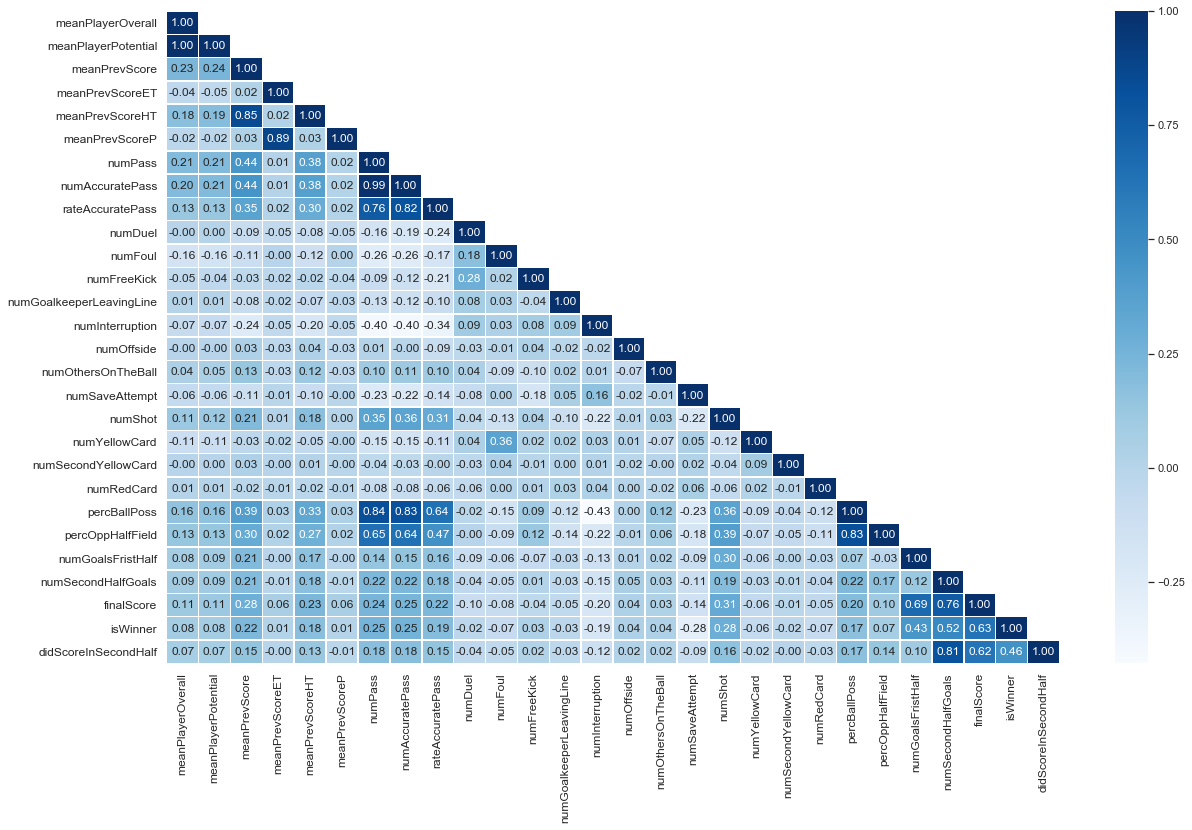

In [276]:
plot_corr_matrix(df)

### Scatter matrix

In [262]:
def corrfunc(x, y, **kws):
    (r, p) = pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f} ".format(r),
                xy=(.5, .9), xycoords=ax.transAxes)

In [267]:
def scatter_matrix (df, atts, target=None, save=False, title=''):
    sns.set(style="ticks")
    if target:
        sns_plot = sns.pairplot(df[atts], hue=target)
    else:
        sns_plot = sns.pairplot(df[atts])
        sns_plot.map(corrfunc)
    if save:
        plt.savefig('plots/'+title + '.pdf')
    else:
        plt.show()

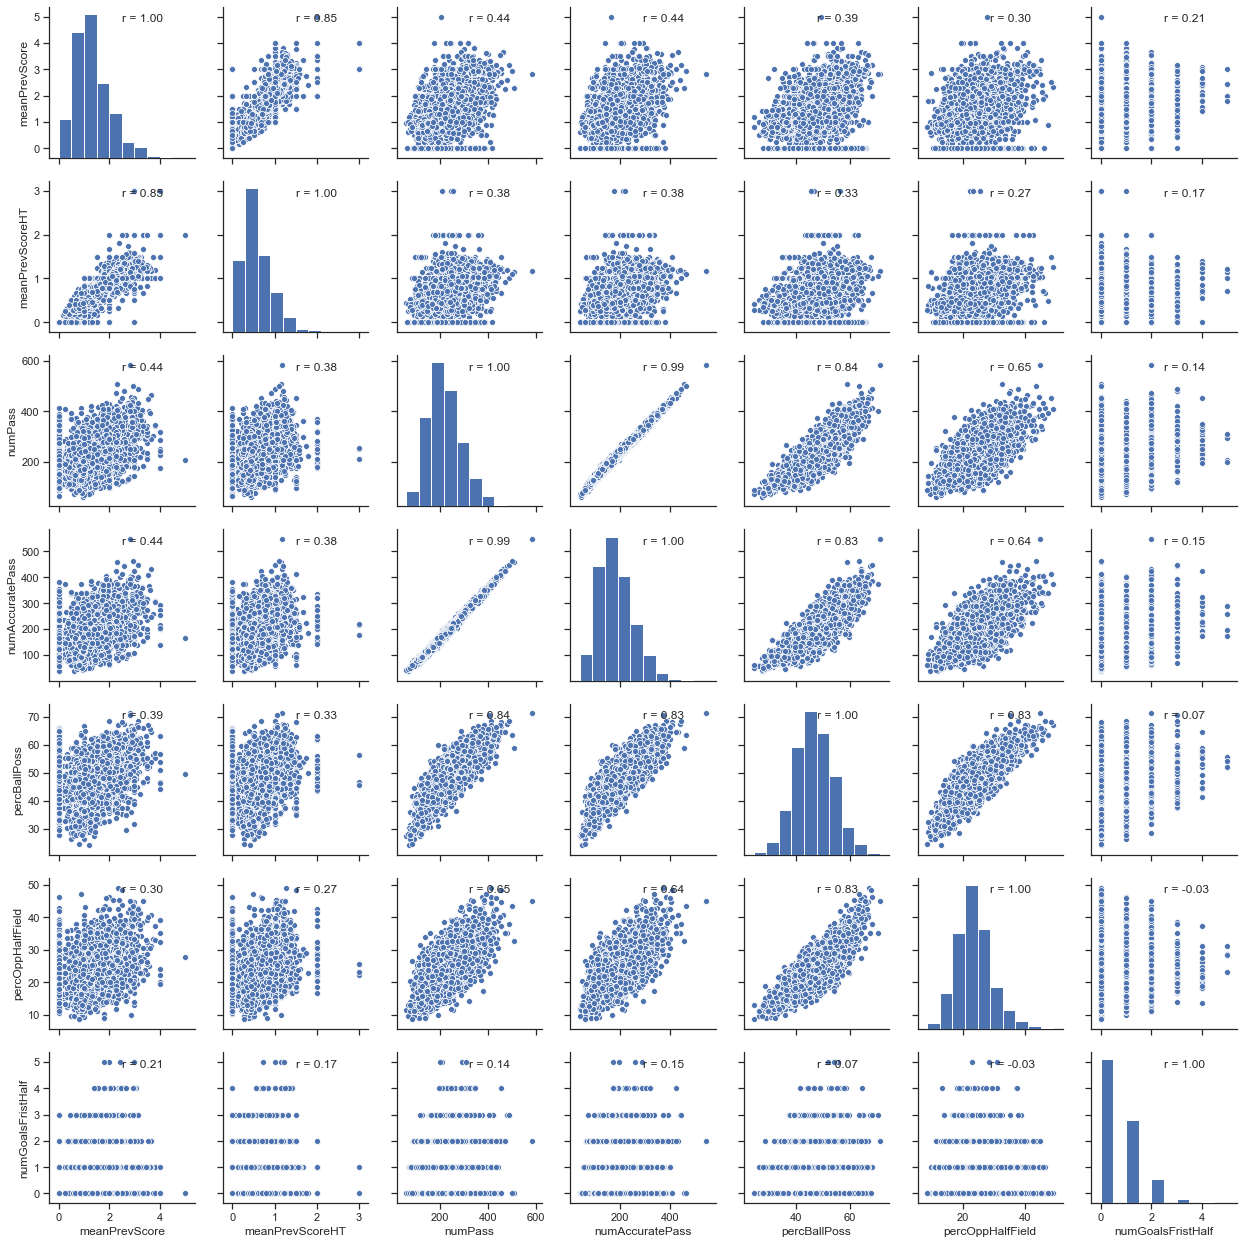

In [269]:
scatter_matrix(df.drop([target2],axis=1), ['meanPrevScore', 'meanPrevScoreHT', 
                                           'numPass', 'numAccuratePass', 
                                           'percBallPoss', 'percOppHalfField', 'numGoalsFristHalf'])

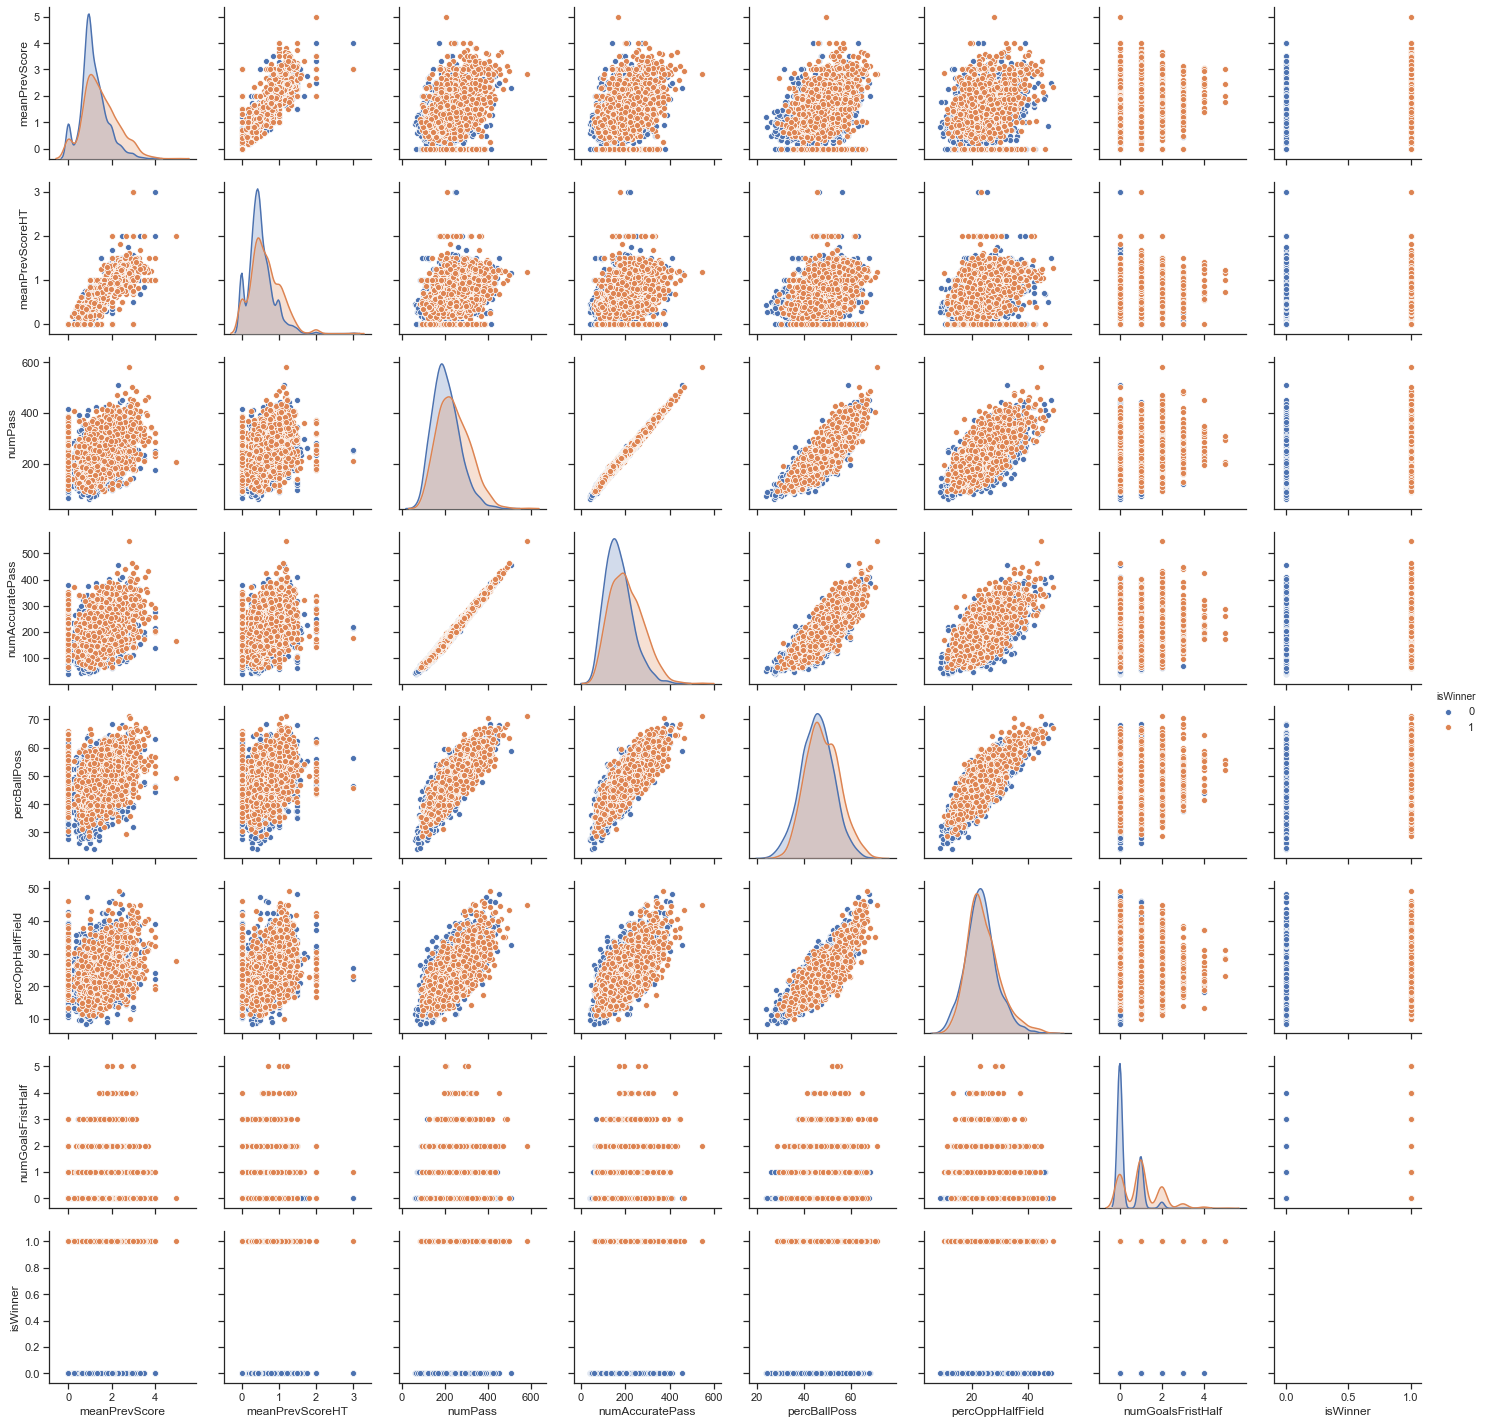

In [268]:
scatter_matrix(df.drop([target2],axis=1), ['meanPrevScore', 'meanPrevScoreHT', 
                                           'numPass', 'numAccuratePass', 
                                           'percBallPoss', 'percOppHalfField', 'numGoalsFristHalf', target1], 
                                            target1)

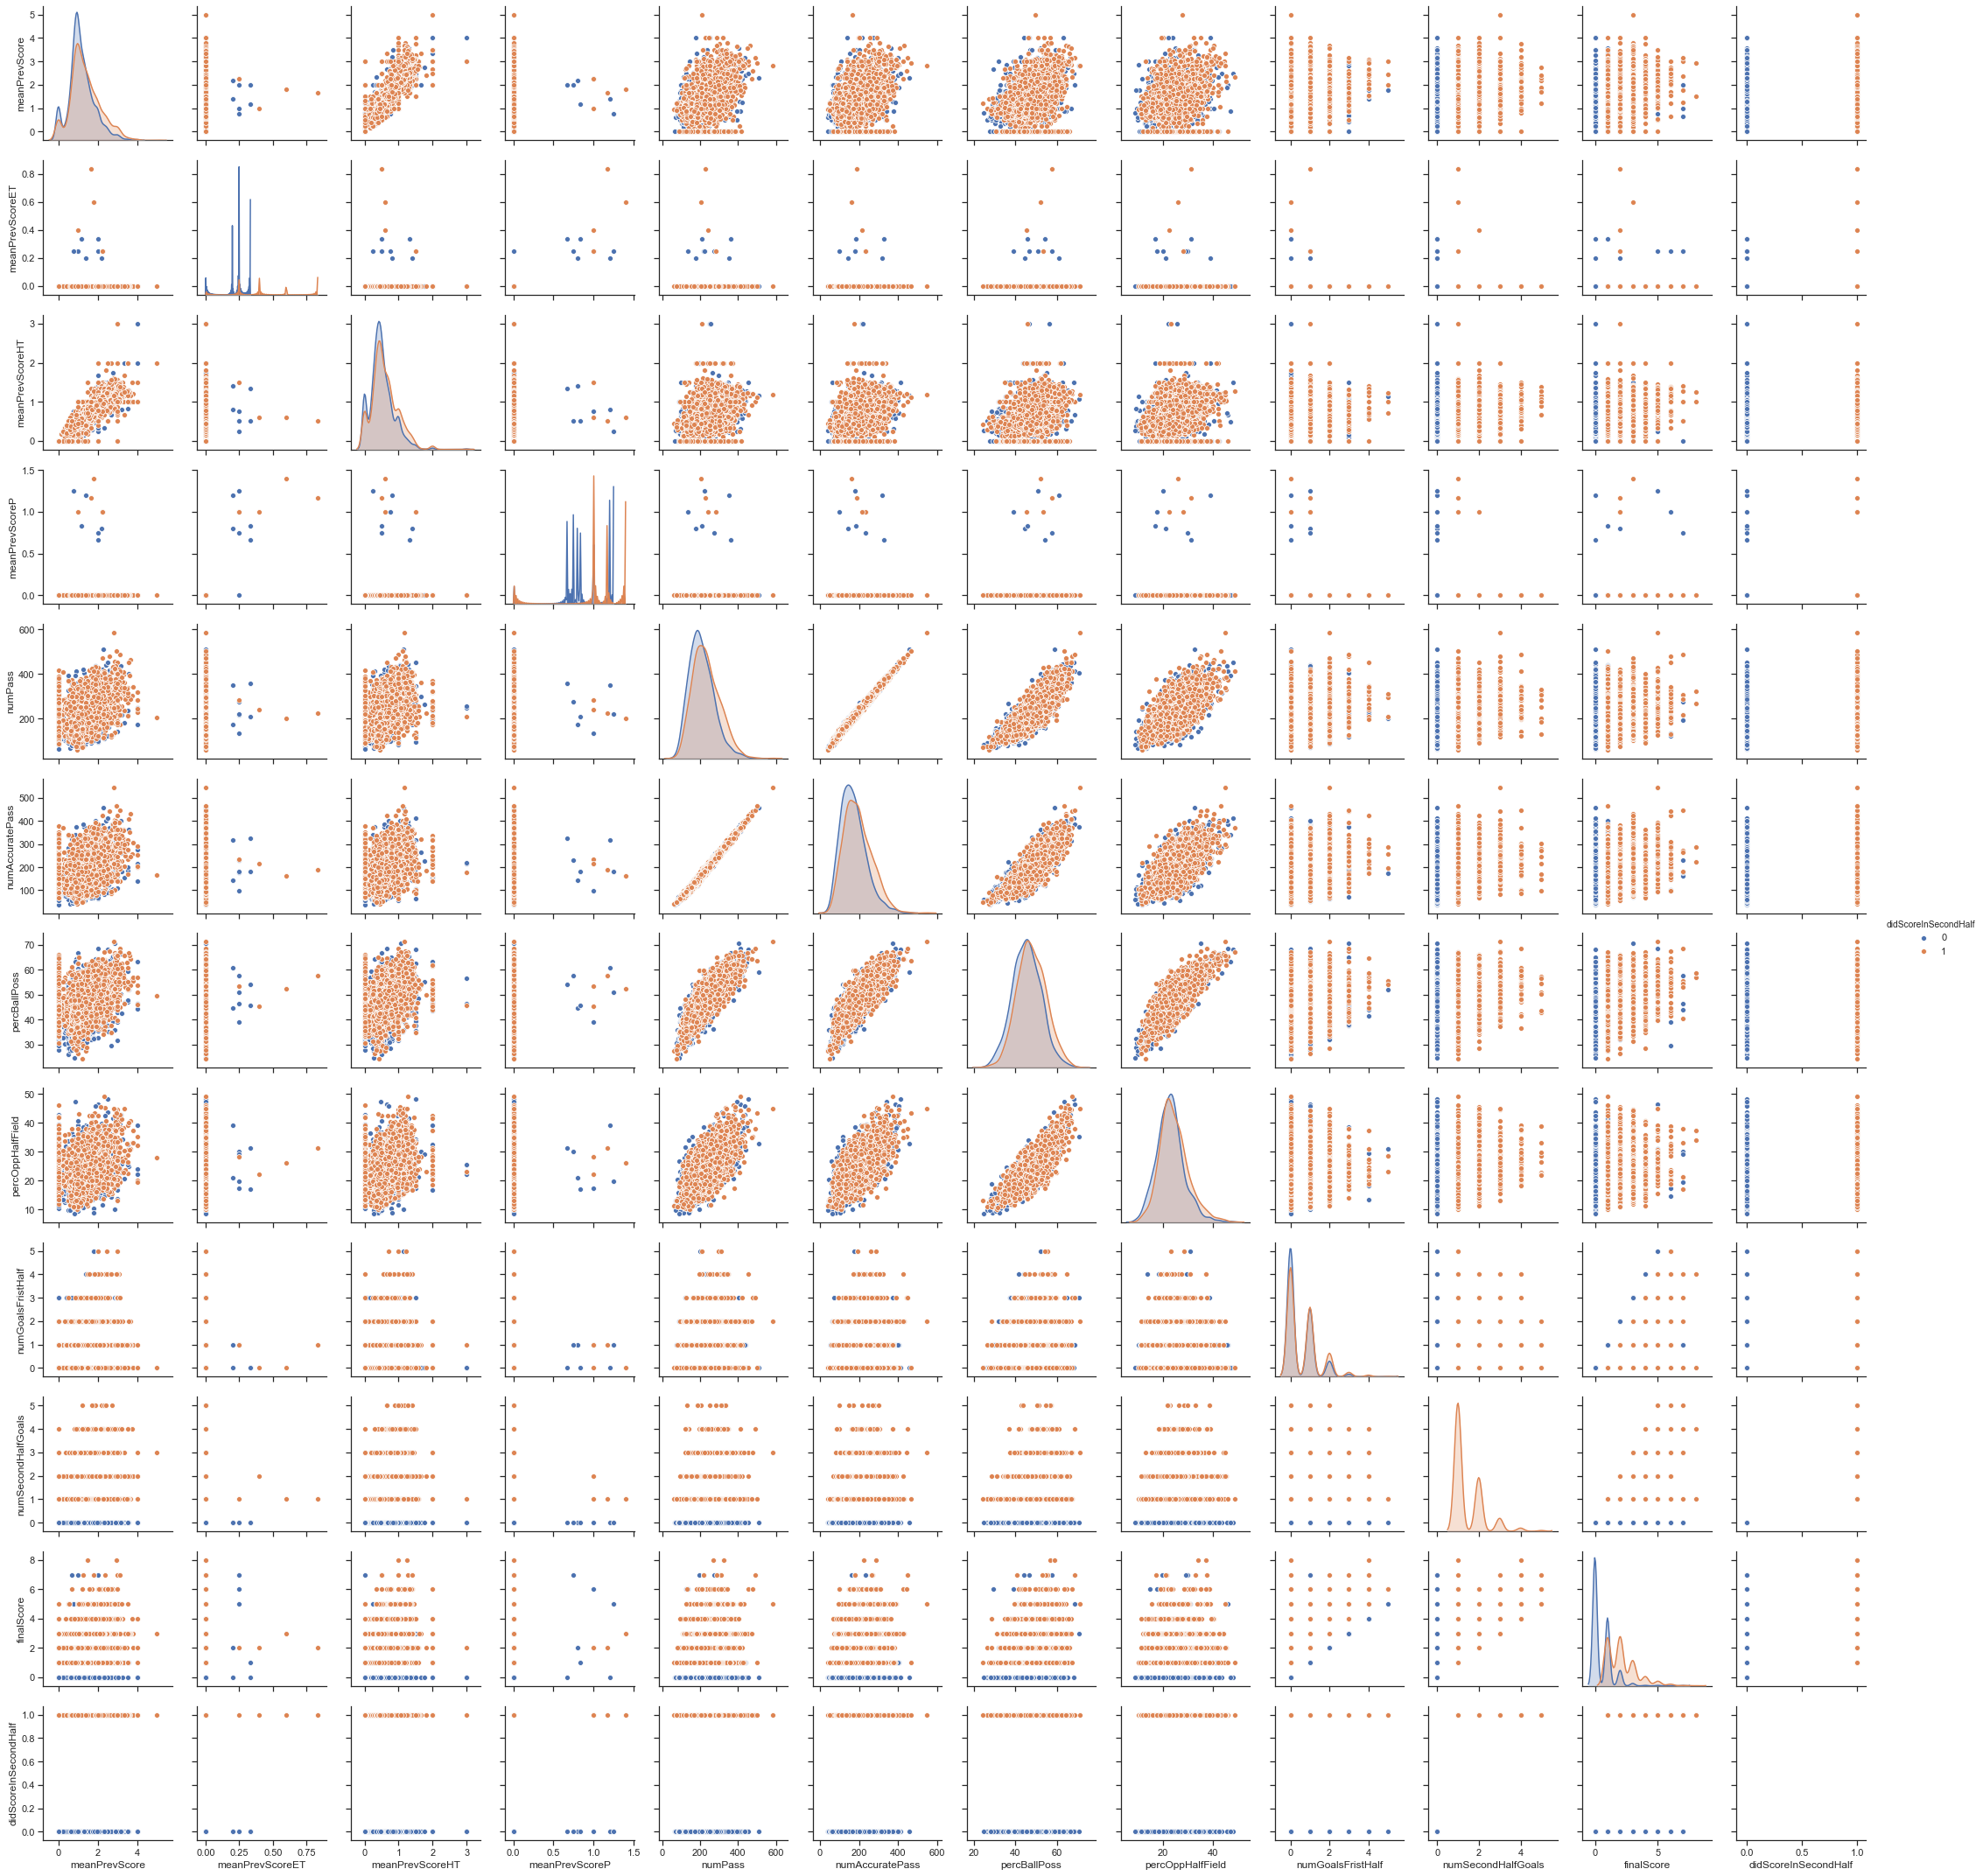

In [240]:
scatter_matrix(df.drop([target1],axis=1), ['meanPrevScore', 'meanPrevScoreET', 'meanPrevScoreHT', 'meanPrevScoreP',
                        'numPass', 'numAccuratePass',
                        'percBallPoss', 'percOppHalfField',
                        'numGoalsFristHalf', 'numSecondHalfGoals', 'finalScore',
                        target2], target2)

### Scatter plots

In [231]:
def plot_scatter(df, xLabel, yLabel, save=False, title=''):
    plt.figure(figsize=(6,4))
    
    plt.scatter(x=df[xLabel], y=df[yLabel], color=b5, alpha=0.2)
    plt.xlabel(xLabel,fontsize=12)
    plt.ylabel(yLabel,fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    if save:
        plt.savefig('plots/'+title + '.pdf')
    else:
        plt.show()


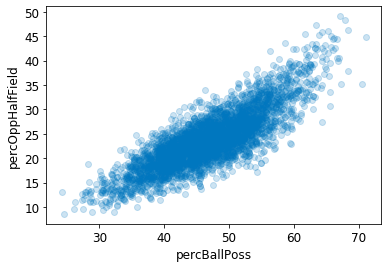

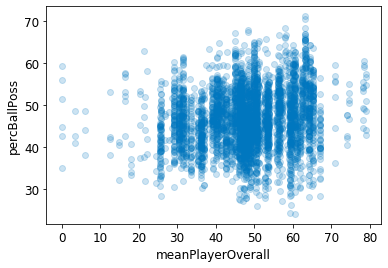

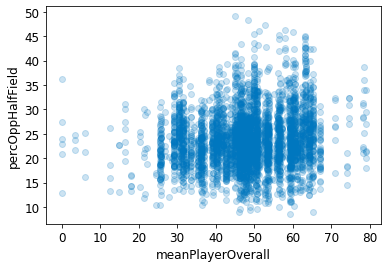

In [244]:
plot_scatter(df, yLabel='percOppHalfField', xLabel='percBallPoss')
plot_scatter(df, xLabel='meanPlayerOverall', yLabel='percBallPoss')
plot_scatter(df, xLabel='meanPlayerOverall', yLabel='percOppHalfField')

## Histogram

#### Mean of the number each event

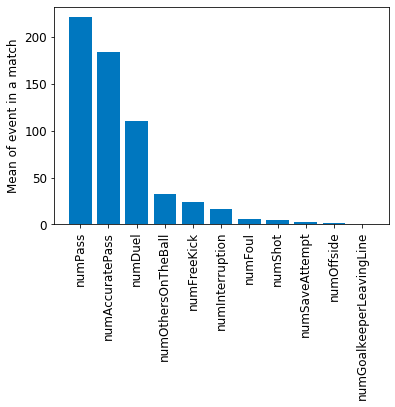

In [126]:
plt.figure(figsize=(6,4))
means = df_noTarget.mean()[['numPass', 'numAccuratePass', 'numDuel', 'numFoul', 'numFreeKick', 
                    'numGoalkeeperLeavingLine', 'numInterruption', 'numOffside', 
                    'numOthersOnTheBall', 'numSaveAttempt', 'numShot']].sort_values(ascending=False)
plt.bar(means.index, means.values, color=b5)
plt.ylabel('Mean of event in a match', fontsize=12)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [37]:
def plot_histogram_per_attribute(df, att, size):
    fig = plt.figure(figsize=(size, size)) 
    fig_dims = (2, 2)
    
    plt.subplot2grid(fig_dims, (0, 0)) #(0,1), (1,0) (1,1)
    plt.hist(df[att], #bins=20, normed=True, 
         histtype='stepfilled', color=b5,
         edgecolor='none')
    plt.title(att.title() + ' Histogram')
    
    plt.show()
    #plt.savefig("/home/daniele/dm-local/age_ba_pa_limit_hist.pdf")


In [40]:
def plot_histogram_vect(vect, size, tit=None):
    fig = plt.figure(figsize=(size, size)) 
    fig_dims = (2, 2)
    
    plt.subplot2grid(fig_dims, (0, 0)) #(0,1), (1,0) (1,1)
    plt.hist(vect, #bins=20, normed=True, 
         histtype='stepfilled', color=b5,
         edgecolor='none')
    plt.title(tit.title() + ' Histogram')
    
    plt.show()
    #plt.savefig("/home/daniele/dm-local/age_ba_pa_limit_hist.pdf")


## Density plot

For each attribute we show the density plot twice, one for each target field

In [104]:
# Plotting the KDE Plot 
def kde_att_target (df, att, target, save=False, title=''):
    plt.figure(figsize=(6,4))
    sns.kdeplot(df.loc[(df[target]==0), att], color=b4, shade=True, Label=target + ' = 0') 
    sns.kdeplot(df.loc[(df[target]==1), att], color=b6, shade=True, Label=target + ' = 1') 

    plt.xlabel(att,fontsize=12)
    plt.ylabel('Probability Density', fontsize=12)
    plt.xticks(rotation=90, fontsize=12)
    plt.yticks(fontsize=12)
    if save:
        plt.savefig('plots/'+title + '.pdf')
    else:
        plt.show()


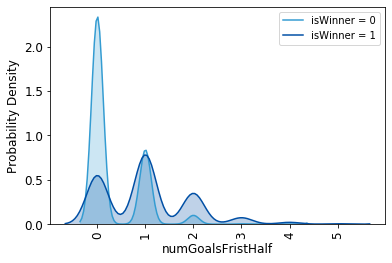

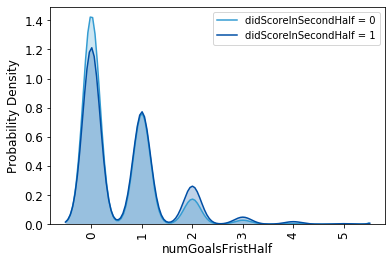

In [105]:
kde_att_target(df, 'numGoalsFristHalf', target1, save=True, title='numGoalsFirstHalf_t1')
kde_att_target(df, 'numGoalsFristHalf', target2, save=True, title='numGoalsFirstHalf_t2')

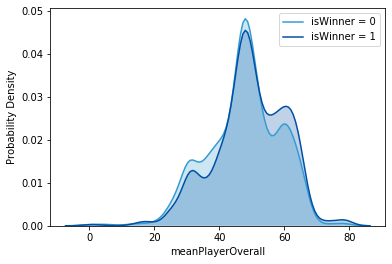

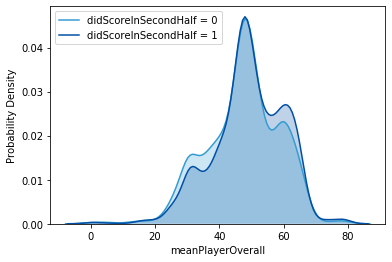

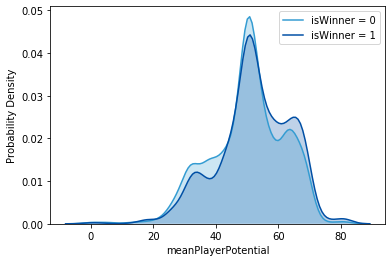

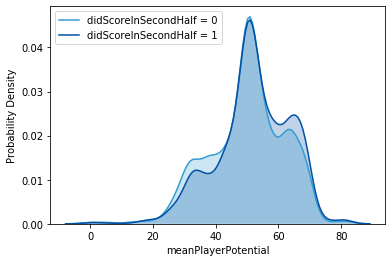

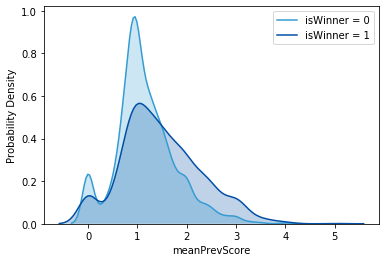

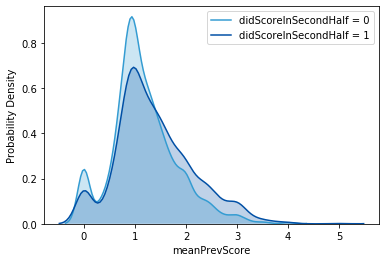

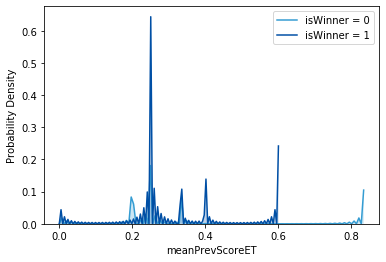

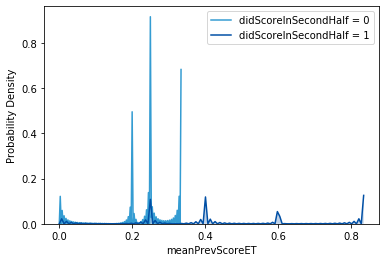

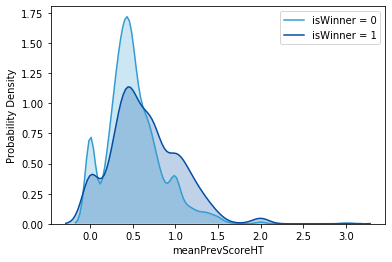

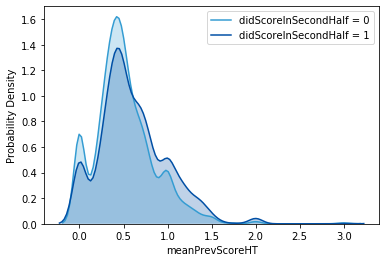

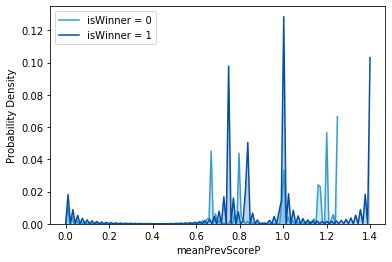

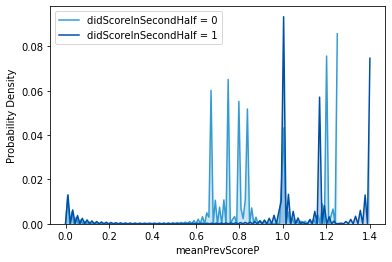

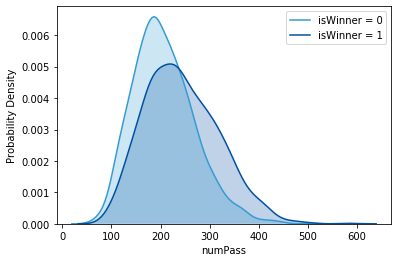

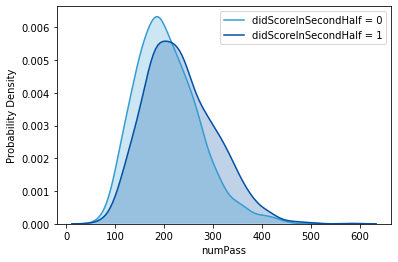

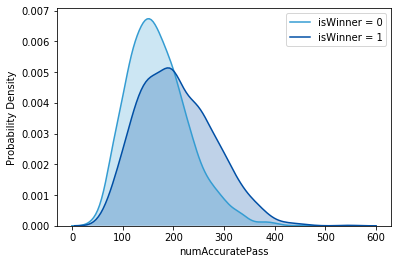

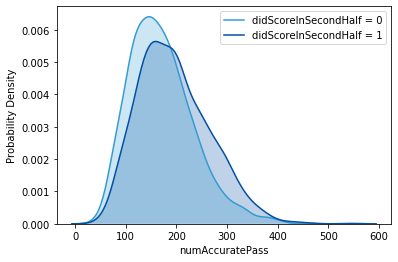

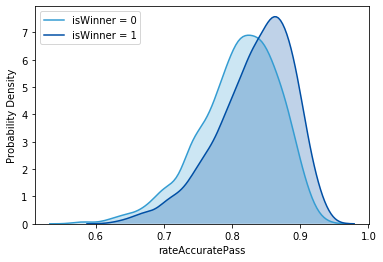

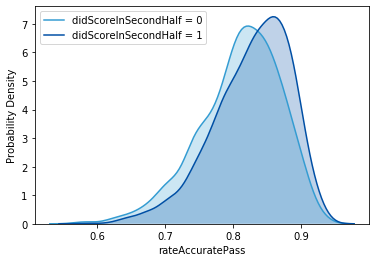

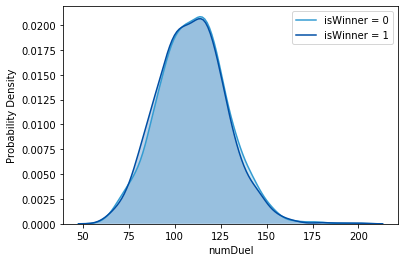

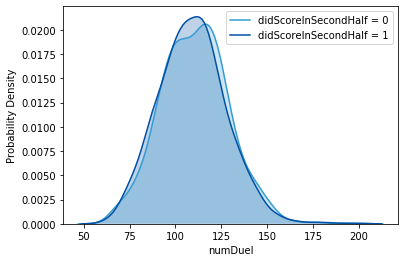

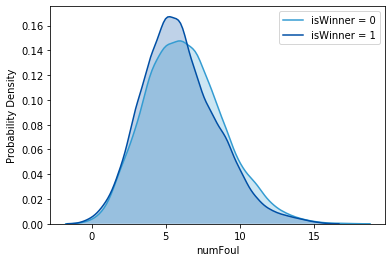

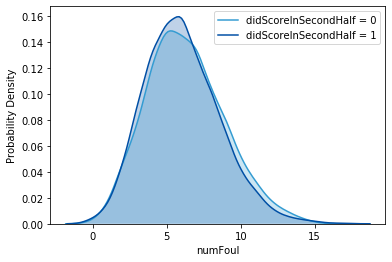

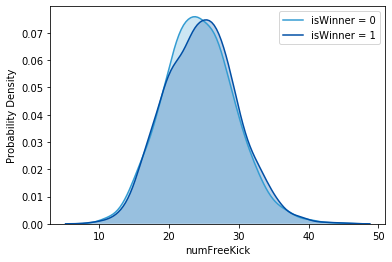

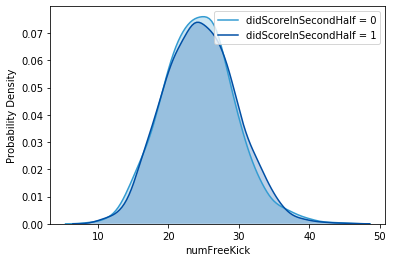

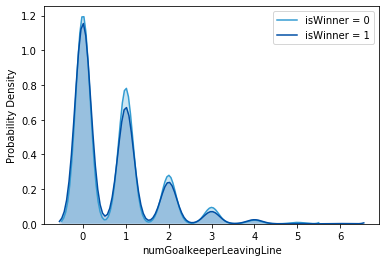

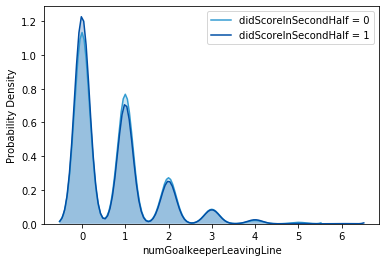

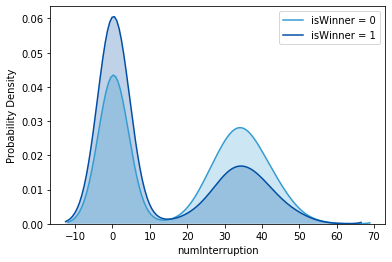

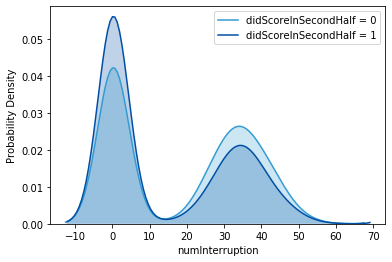

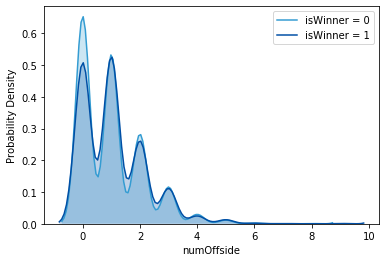

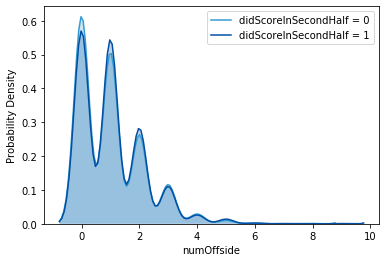

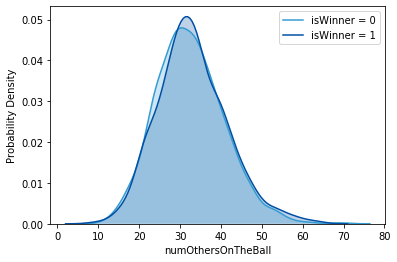

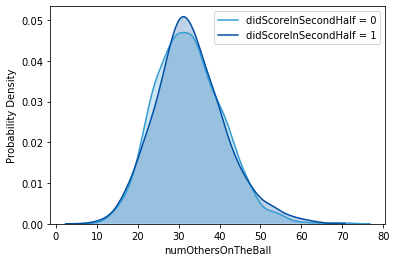

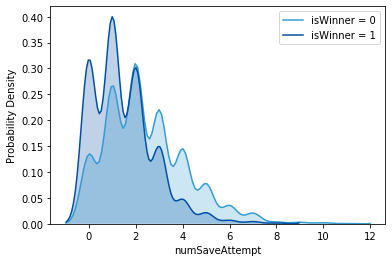

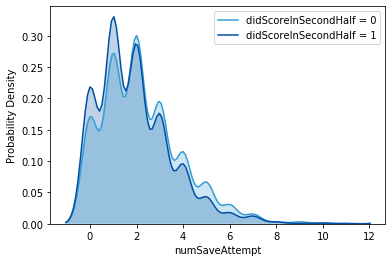

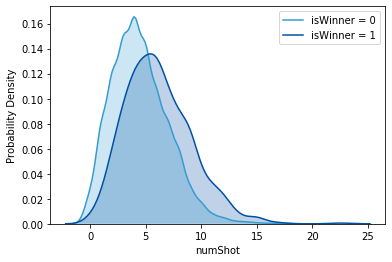

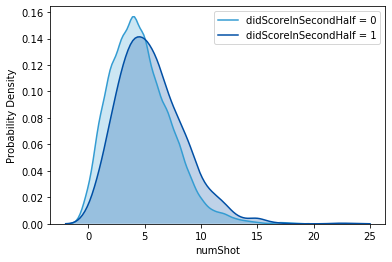

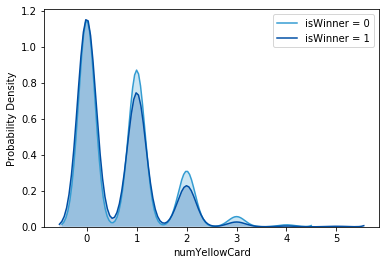

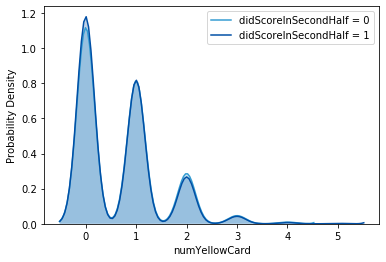

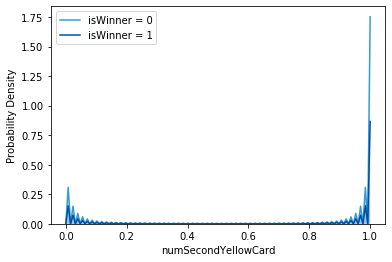

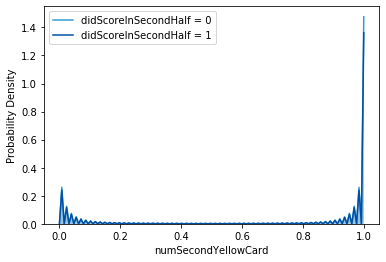

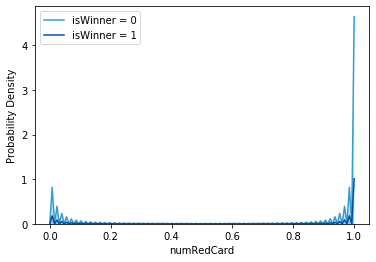

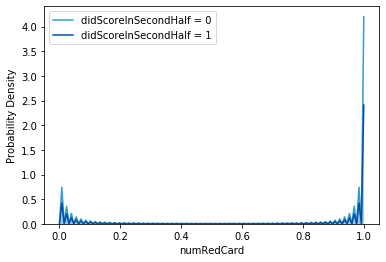

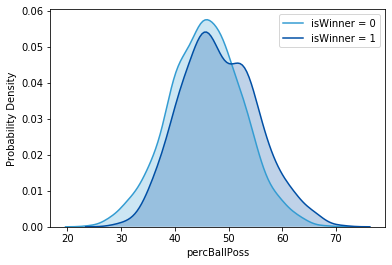

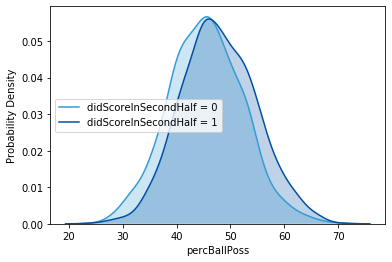

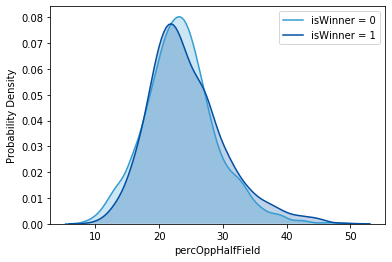

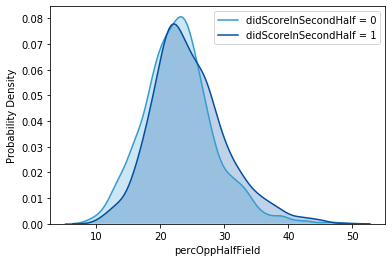

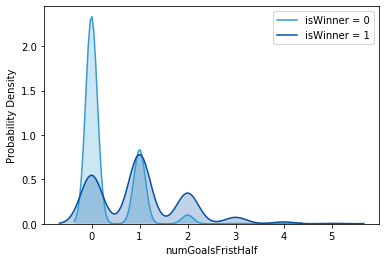

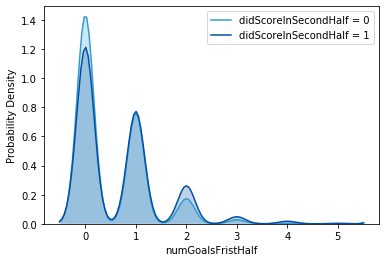

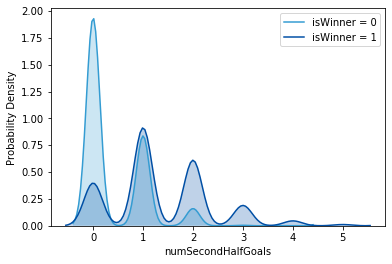

/Users/martincastellani/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/martincastellani/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


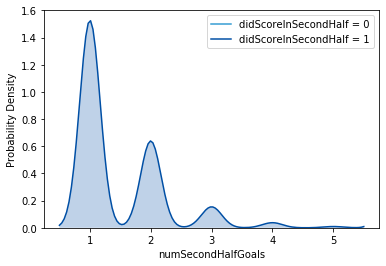

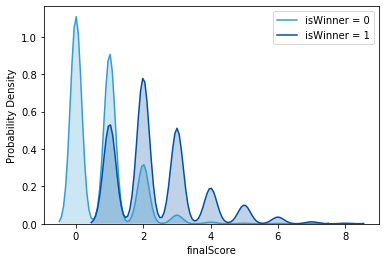

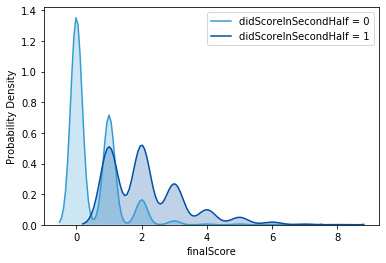

In [14]:
#for e in ['numPass', 'numAccuratePass', 'numDuel', 'numFoul', 'numFreeKick', 'numGoalkeeperLeavingLine', 'numInterruption', 'numOffside', 'numOthersOnTheBall', 'numSaveAttempt', 'numShot']:
for e in df_noTarget.columns:
    kde_att_target(df, e, target1)
    kde_att_target(df, e, target2)

### Crosstab

### Plot cutting the datframe in bins

In [237]:
def plot_crosstab_hist(df, att, nB, save=False, title=''):
    plt.figure(figsize=(6,4))
    
    plt.hist(df[att], bins=nB, rwidth=0.5, color=b5)
    
    plt.xlabel(att, fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    if save:
        plt.savefig('plots/'+title + '.pdf')
    else:
        plt.show()

In [110]:
#this function plot the crosstab for an attribute and one target
def plot_crosstab_target(df, attribute, target, nB, save=False, title=''):
    plt.figure(figsize=(6,4))
    crosstab = pd.crosstab(pd.cut(df[attribute], nB), df[target])
    # Normalize the cross tab to sum to 1:
    crosstab_normalized = crosstab.div(crosstab.sum(1).astype(float), axis=0)
    crosstab_normalized.plot(kind='bar', stacked=True, color=[b3, b5])
    
    plt.xlabel(attribute, fontsize=12)
    plt.xticks(rotation=90, fontsize=12)
    plt.yticks(fontsize=12)
    
    if save:
        plt.savefig('plots/'+title + '.pdf')
    else:
        plt.show()

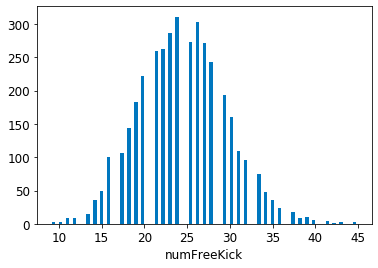

<Figure size 432x288 with 0 Axes>

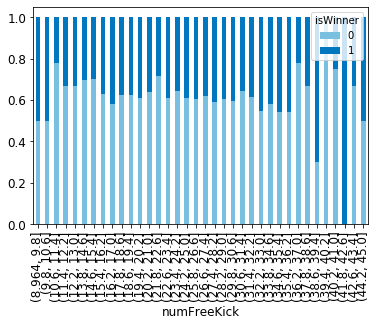

<Figure size 432x288 with 0 Axes>

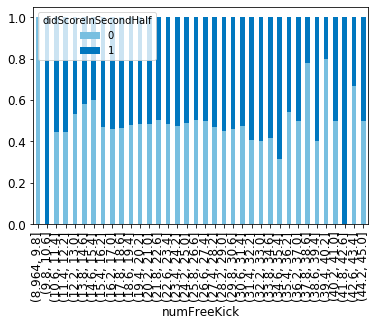

In [240]:
numBins = 45
plot_crosstab_hist(res, 'numFreeKick', numBins)
plot_crosstab_target(res, 'numFreeKick', target1, numBins)
plot_crosstab_target(res, 'numFreeKick', target2, numBins)

### Plot without cutting the dataframe in bins

In [123]:
def plot_crosstab_noCut_hist(df, att, save=False, title=''):
    plt.figure(figsize=(6,4)) 
    cnt = Counter(list(df[att]))
    keys = sorted(cnt.keys())
    
    plt.bar(keys, [cnt[k] for k in keys], width=0.5, color=b5)
    #plt.title(att + ' Histogram')
    
    plt.xlabel(att, fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    if save:
        plt.savefig('plots/'+title + '.pdf')
    else:
        plt.show()

In [233]:
def plot_crosstab_noCut_target(df, att, target, save=False, title=''):
    plt.figure(figsize=(6,4)) 
    
    crosstab = pd.crosstab(df[att], df[target])
    # Normalize the cross tab to sum to 1:
    crosstab_normalized = crosstab.div(crosstab.sum(1).astype(float), axis=0)
    
    b1 = plt.bar(crosstab_normalized.index, crosstab_normalized[0], color=b3, width=0.5)
    b2 = plt.bar(crosstab_normalized.index, crosstab_normalized[1],
                 bottom=crosstab_normalized[0], color=b5, width=0.5)
    plt.xlabel(att, fontsize=12)
    plt.xticks(rotation = 0, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend((b1[0],b2[0]), ('0','1'), title=target)
    
    if save:
        plt.savefig('plots/'+title + '.pdf')
    else:
        plt.show()

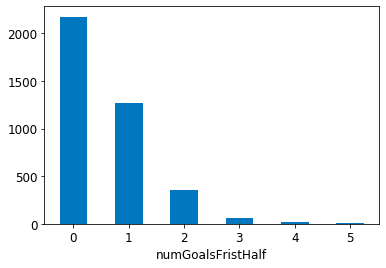

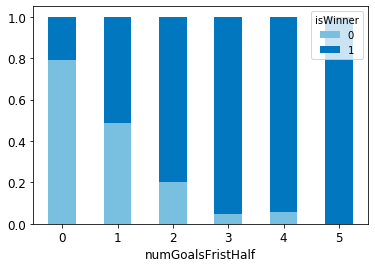

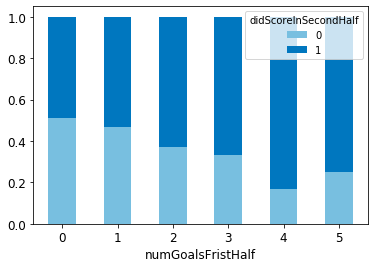

In [235]:
plot_crosstab_noCut_hist(res, 'numGoalsFristHalf')
plot_crosstab_noCut_target(res, 'numGoalsFristHalf', target1)
plot_crosstab_noCut_target(res, 'numGoalsFristHalf', target2)

### Features importance

In [205]:
def plot_features_importance (X, y, n = None, save=False, title=''):
    plt.figure(figsize=(6,4))
    if n == None:
        n = len(X.columns)
    model = ExtraTreesClassifier()
    model.fit(X,y)
    #print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
    #plot graph of feature importances for better visualization
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    #feat_importances.nlargest(n).plot(kind='barh')
    plt.barh(feat_importances.nlargest(n).index, feat_importances.nlargest(n).values, height=0.5, color=b5)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

/Users/martincastellani/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


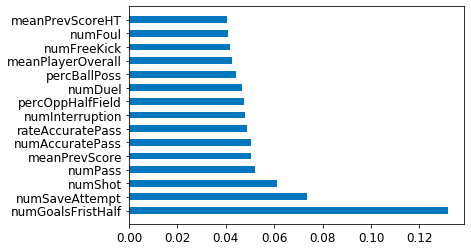

/Users/martincastellani/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


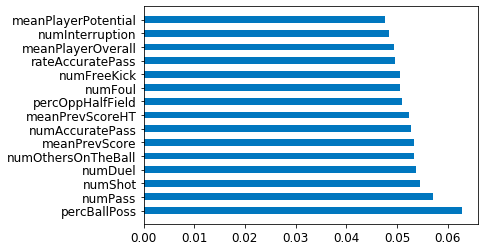

In [206]:
plot_features_importance( df_noTarget.drop(['numSecondHalfGoals', 'finalScore'], axis=1), df[target1], 15)
plot_features_importance( df_noTarget.drop(['numSecondHalfGoals', 'finalScore'], axis=1), df[target2], 15)